# Can you predict which NBA players will make the "All-Star" team?

## Part one: Clean the data

#### Import libraries

In [1]:
import time
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
from pandas_profiling import ProfileReport
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

#### Load 'player_data.csv' 

In [2]:
df = pd.read_csv(r'C:\Users\tulio\Documents\Machine learning\Interview tests\The Keenfolks_DS\player_data.csv')
print('Shape:', df.shape)
df.head(3)

Shape: (24691, 30)


,Unnamed: 0,Year,Player,Pos,Age,Tm,G,PER,TS%,ORB%,...,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,0.368,NaN,...,NaN,0.279,0.279,0.705,NaN,176.0,NaN,NaN,NaN,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,0.435,NaN,...,NaN,0.372,0.372,0.708,NaN,109.0,NaN,NaN,NaN,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,0.394,NaN,...,NaN,0.349,0.349,0.698,NaN,140.0,NaN,NaN,NaN,438.0


#### Drop the first column

In [3]:
df = df.drop(['Unnamed: 0'], axis = 1)
df.shape

(24691, 29)

#### Remove null values from "Players" column

In [4]:
temp = df.Player.isna().sum()

df = df.dropna(axis = 0, subset = ['Player'])

print('Null values before dropping: ', temp)
print('Null values after dropping: ',df.Player.isna().sum())

Null values before dropping:  67
Null values after dropping:  0


#### Replace null values with 0's in the '3P%' column

In [5]:
temp = df['3P%'].isna().sum()

df['3P%'].fillna(0, inplace = True)

print('Null values before replacing: ', temp)
print('Null values after replacing: ', df['3P%'].isna().sum())

Null values before replacing:  9208
Null values after replacing:  0


#### Remove rows for players who started their careers before the 1980 season

In [6]:
df = df[df.Year >= 1980].astype({'Year': int})
df.reset_index(drop=True, inplace=True)
df.shape

(18927, 29)

#### Load in the 'all_star_appearances.pickle' file and use this data to create a column called 'all_star' that indicates whether or not a player made the All-Star team for a given year
- This file is a dictionary in which the keys are players who've made an All-Star team in their careers
- The values are all the years that the corresponding player made an All-Star team

#### Make sure this column is binary where 1 = Made All-Star team, and 0 = Did not make All-Star team

In [7]:
with open('all_star_appearances.pickle', 'rb') as pickle_file:
    stars_pickle = pickle.load(pickle_file)
    
stars_pickle

defaultdict(set,
            {'Julius Erving': {1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987},
             'Jack Sikma': {1980, 1981, 1982, 1983, 1984, 1985},
             'Dan Roundfield': {1980, 1981, 1982},
             'Dennis Johnson': {1980, 1981, 1982, 1985},
             'Tiny Archibald': {1980, 1981, 1982},
             'Kareem Abdul-Jabbar': {1980,
              1981,
              1982,
              1983,
              1984,
              1985,
              1986,
              1987,
              1988,
              1989},
             'Eddie Johnson': {1980, 1981},
             'Otis Birdsong': {1980, 1981, 1984},
             'Magic Johnson': {1980,
              1982,
              1983,
              1984,
              1985,
              1986,
              1987,
              1988,
              1989,
              1990,
              1991,
              1992},
             'Kermit Washington': {1980},
             'Bill Cartwright': {1980},
             'John Dr

In [8]:
df['Player'] = df['Player'].str.replace('*', '')   # cleaning player's name

In [9]:
tempdic = {}      # Dictionary for All-Stars players
for name in stars_pickle.keys():         
    tempdic[name] = list(stars_pickle[name])
    
names = []        # Players that were All-Star
years = []        # Year that Players were All-Stars
for key, value in stars_pickle.items():
    names.append(key)
    years.append(list(value))
    
year_name = []    # Player's name and Year of All-Star
for index, year_list in enumerate(years):
    for index_list, value in enumerate(year_list):
        year_name.append([value, names[index], 1])

year_name_df = pd.DataFrame(year_name, columns = ['Year', 'Player', 'all_star'])
year_name_df.head(3)

,Year,Player,all_star
0,1984,Julius Erving,1
1,1985,Julius Erving,1
2,1986,Julius Erving,1


In [10]:
df3 = pd.merge(df, year_name_df, on = ['Year', 'Player'], how = 'left')   # Left Joint to Merge the dataframes
df3['all_star'] = df3.all_star.fillna(0).astype(int)                      # fill n/a with zero (no all-stars)
df3.tail(3)

,Year,Player,Pos,Age,Tm,G,PER,TS%,ORB%,DRB%,...,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PTS,all_star
18924,2017,Stephen Zimmerman,C,20.0,ORL,19.0,7.3,0.346,10.8,24.9,...,0.323,0.323,0.600,35.0,4.0,2.0,5.0,3.0,23.0,0
18925,2017,Paul Zipser,SF,22.0,CHI,44.0,6.9,0.503,1.9,14.2,...,0.451,0.473,0.775,125.0,36.0,15.0,16.0,40.0,240.0,0
18926,2017,Ivica Zubac,C,19.0,LAL,38.0,17.0,0.547,7.1,21.9,...,0.536,0.529,0.653,159.0,30.0,14.0,33.0,30.0,284.0,0


## Part 2: Exploratory data analysis

#### Generate descriptive stats for the features

In [11]:
df3.describe().round(3)

,Year,Age,G,PER,TS%,ORB%,DRB%,TRB%,AST%,STL%,...,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PTS,all_star
count,18927.000,18927.000,18927.000,18922.000,18851.000,18922.000,18922.000,18922.000,18922.000,18922.000,...,18810.000,18839.000,18182.000,18927.000,18927.000,18927.000,18927.000,18927.000,18927.000,18927.000
mean,2000.272,26.838,49.640,12.396,0.504,6.154,13.742,9.949,13.098,1.650,...,0.457,0.464,0.722,203.935,110.586,38.771,24.172,72.571,486.034,0.049
std,10.692,4.000,26.693,6.200,0.095,4.958,6.608,5.064,9.569,1.027,...,0.100,0.098,0.147,202.432,137.328,37.830,36.472,66.602,479.419,0.217
min,1980.000,18.000,1.000,-90.600,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1992.000,24.000,26.000,9.700,0.473,2.500,8.900,6.000,6.300,1.100,...,0.423,0.433,0.660,46.000,17.000,9.000,3.000,17.000,94.000,0.000
50%,2001.000,26.000,55.000,12.700,0.516,5.300,12.800,9.200,10.400,1.500,...,0.467,0.475,0.750,145.000,61.000,28.000,11.000,54.000,338.000,0.000
75%,2010.000,30.000,75.000,15.600,0.551,9.000,18.100,13.400,17.900,2.100,...,0.503,0.510,0.813,295.000,151.000,58.000,29.000,110.000,750.000,0.000
max,2017.000,44.000,85.000,129.100,1.136,100.000,100.000,100.000,100.000,24.200,...,1.000,1.500,1.000,1530.000,1164.000,301.000,456.000,464.000,3041.000,1.000


#### Create a corr map of the features

<AxesSubplot:>

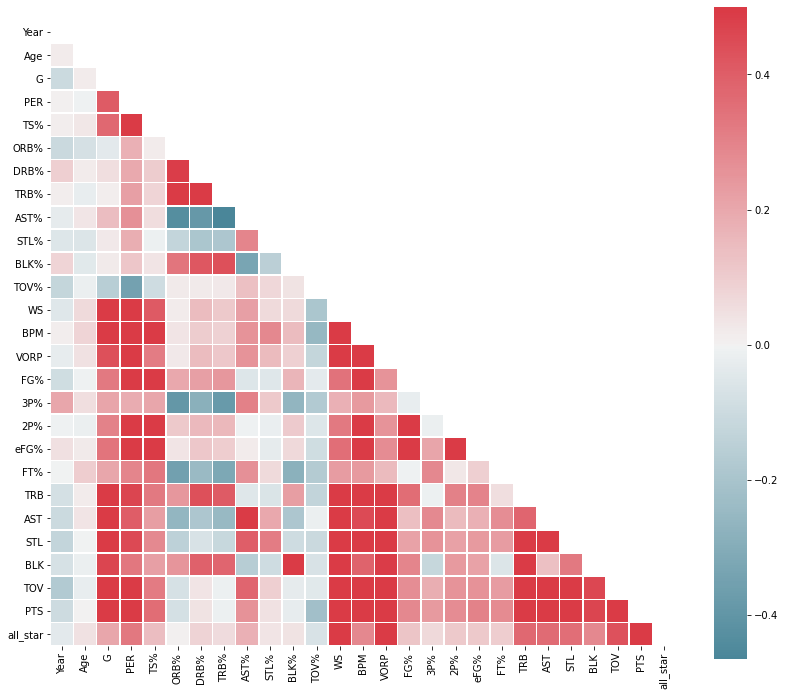

In [12]:
# Heatmap

corr = df3.corr()
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
fig, axes = plt.subplots(1, 1, figsize = (14, 12))
cmap = sb.diverging_palette(220, 10, as_cmap = True)

sb.heatmap(corr, mask = mask, square = True, annot = False, linewidth = 0.5,
           ax = axes, cmap = cmap, vmax = 0.5, center = 0)

#### Analysis of All-Star Players

In [13]:
# How many All-Stara each year

temp0 = df3.groupby('Year').count()
temp0 = temp0.loc[:, 'all_star']

temp1 = df3[df3.all_star == 1].groupby('Year').count()
temp1 = temp1.loc[:, 'all_star']

per_year = pd.concat([temp0, temp1], keys = ['all_players', 'all_star'], axis = 1)
per_year['Ratio%'] = ((per_year['all_star']/per_year['all_players'])*100).round(2)
per_year = per_year.dropna()

(1979.0, 2018.0)

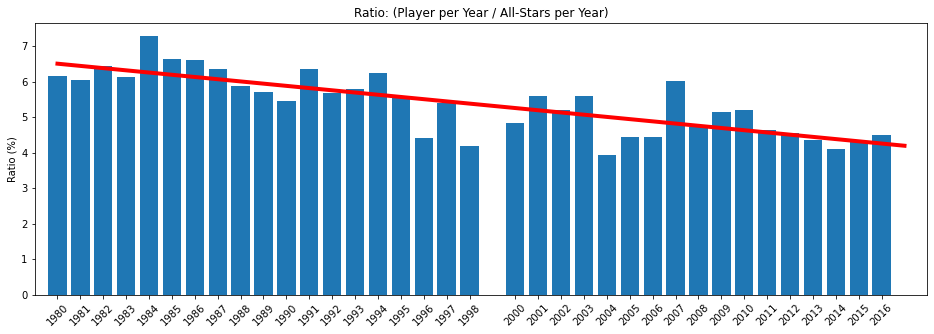

In [14]:
x = per_year.index.to_numpy().reshape(-1, 1)
y = per_year['Ratio%'].to_numpy()

# Building a Linear regression
model = LinearRegression()    
model.fit(x, y)
x_test = np.linspace(1980,2017)
y_test = model.predict(x_test[:,None])

# Plotting bar chart with linear regression
plt.figure(figsize = (16, 5))
plt.bar(per_year.index, per_year['Ratio%'], align = 'center')
plt.plot(x_test, y_test, color = 'r', linewidth = 4)
plt.xticks(per_year.index, rotation = 45)
plt.ylabel('Ratio (%)')
plt.title('Ratio: (Player per Year / All-Stars per Year)')
plt.xlim(1979, 2018)

- The dataset has no records of All-Star Players in 1999 and 2017, for that reason every record of these years will be removed.
- Also, it is possible to see that the percentage of All-Star players among the total number of players of each year has been decreasing since 1980, it means it has becoming harder to be a All-Star.

In [15]:
temp = df3.shape
df3 = df3[(df3.Year != 1999) & (df3.Year != 2017)]  # Removing records of 1999 and 2017

print('Rows before dropping 2017', temp[0])
print('Rows after dropping 2017', df3.shape[0])

Rows before dropping 2017 18927
Rows after dropping 2017 17825


In [16]:
df3 = df3.dropna()           # Drop rows with null values
df3.shape

(17121, 30)

#### Graph the distibution of the 'Age' feature

<AxesSubplot:title={'center':'All-Star players'}, xlabel='Age', ylabel='Players'>

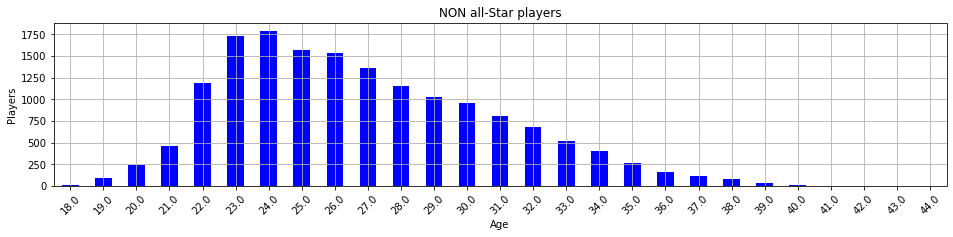

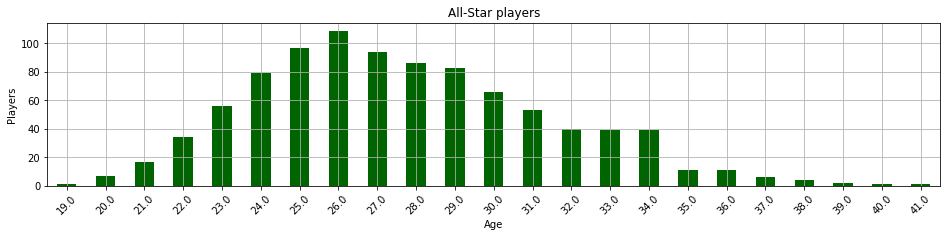

In [17]:
df3[df3.all_star == 0].groupby('Age').count().plot.bar(figsize = (16, 3), 
                                                       title = 'NON all-Star players',
                                                       rot = 45, grid = True,
                                                       xlabel = 'Age', ylabel = 'Players',
                                                       legend = False,
                                                       color = 'blue')

df3[df3.all_star == 1].groupby('Age').count().plot.bar(figsize = (16, 3), 
                                                       title = 'All-Star players',
                                                       rot = 45, grid = True,
                                                       xlabel = 'Age', ylabel = 'Players',
                                                       legend = False,
                                                       color = 'darkgreen')

#### Number of All-Stars by Position

- According to the graphs below, it is possible to see that there are many positions with no records of all-star players
- The 'Pos' features will be kept and categorized.

<AxesSubplot:title={'center':'Number of All-Star by Position'}, xlabel='Age', ylabel='All-Stars'>

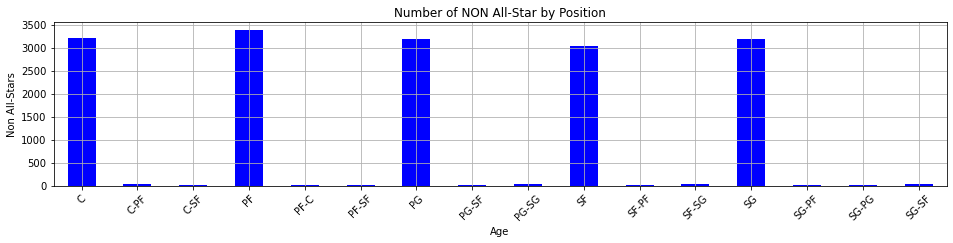

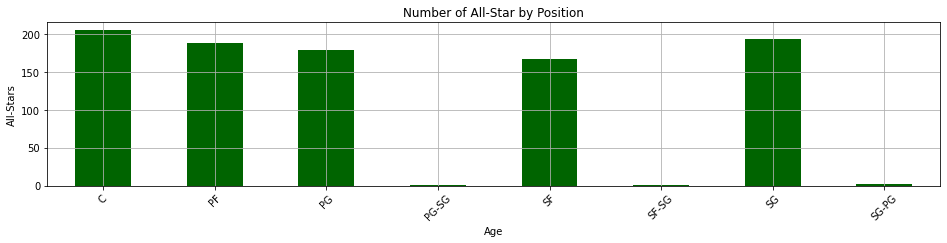

In [18]:
df3[df3.all_star == 0].groupby('Pos').count().plot.bar(figsize = (16, 3), 
                                    title = 'Number of NON All-Star by Position',
                                    rot = 45, grid = True,
                                    xlabel = 'Age', ylabel = 'Non All-Stars',
                                    legend = False,
                                    color = 'blue')

df3[df3.all_star == 1].groupby('Pos').count().plot.bar(figsize = (16, 3), 
                                    title = 'Number of All-Star by Position',
                                    rot = 45, grid = True,
                                    xlabel = 'Age', ylabel = 'All-Stars',
                                    legend = False,
                                    color = 'darkgreen')

#### Analysis of Points records along the years ( FG% | 2P% | 3P% |  eFG% ) 

- These four features are correlated with each other and they have weak correlation with out target

__FG%__
Field Goal Percentage (percentage of total 2 point and 3 point shots that went in, excluding free throws)

__3P%__
3-Point Field Goal Percentage

__2P%__
2-Point Field Goal Percentage

__eFG%__ 
This statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal. For example, suppose Player A goes 4 for 10 with 2 threes, while Player B goes 5 for 10 with 0 threes. Each player would have 10 points from field goals, and thus would have the same effective field goal percentage (50%).


__Results:__
- We see that 3P% (3 Points Percentage) has been increasing since 1980, and we might conclude that all players have been becoming more effective in this type of point since 1980. 
- The features (FG%, 3P%, 2P% and eFG%) are all related to the efficiency of points made by each player. 
- eFG% somehow express the 3P% and 2P% together. 
- 2P% and 3P% has weaker corr to the target compared to the other two features
- I will be doing a average between FG% and eFG%, in order to summarize these correlated features in a single one.

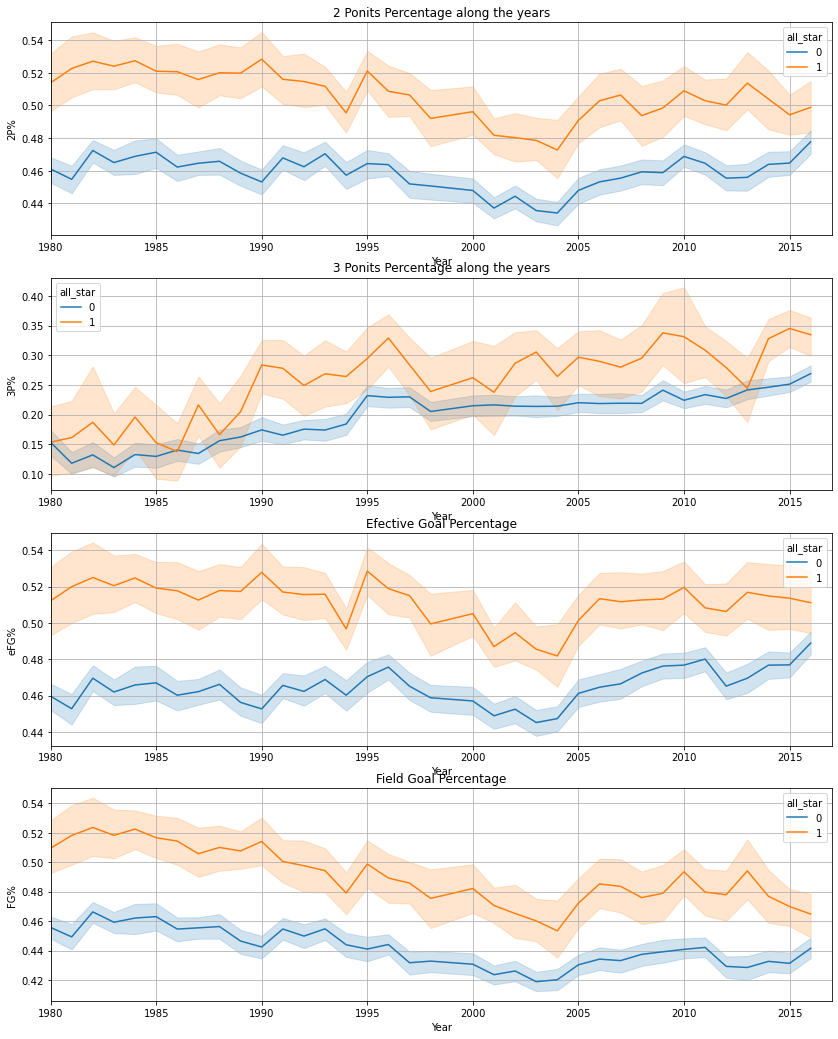

In [19]:
fig, ax = plt.subplots(nrows = 4, figsize = (14, 18))

temp = ['2P%', '3P%', 'eFG%', 'FG%']               # Features to be plotted
title = ['2 Ponits Percentage along the years',    # Graph's titles
         '3 Ponits Percentage along the years',
         'Efective Goal Percentage', 
         'Field Goal Percentage']

for i, v in enumerate(temp):    
    ax[i].grid()
    ax[i].set_xlim(1980, 2017)
    ax[i].set_title(title[i])
    sb.lineplot(x = 'Year', y = v, data = df3, hue = 'all_star', markers=True, ax = ax[i]) 

In [20]:
df3['FG_avg%'] = (df3['FG%'] + df3['eFG%'])/2                # New feature with the average of (FG% and eFG%)
df3 = df3.drop(['FG%', 'eFG%', '2P%', '3P%'], axis = 1)      # drop both features

#### Checking for Outliers

- From the scatter plot below we are going to study some specific outiers (all-star players).
- Some players presented multiple records for the same year but in different teams.
- It might have happened because of these players being traded during the season.
- This can be removed by taking outliers off, which means all-stars who played few games in a season.
- In this case, the 1st quantile of the most correlated features with the target will be removed (where games played < 55)

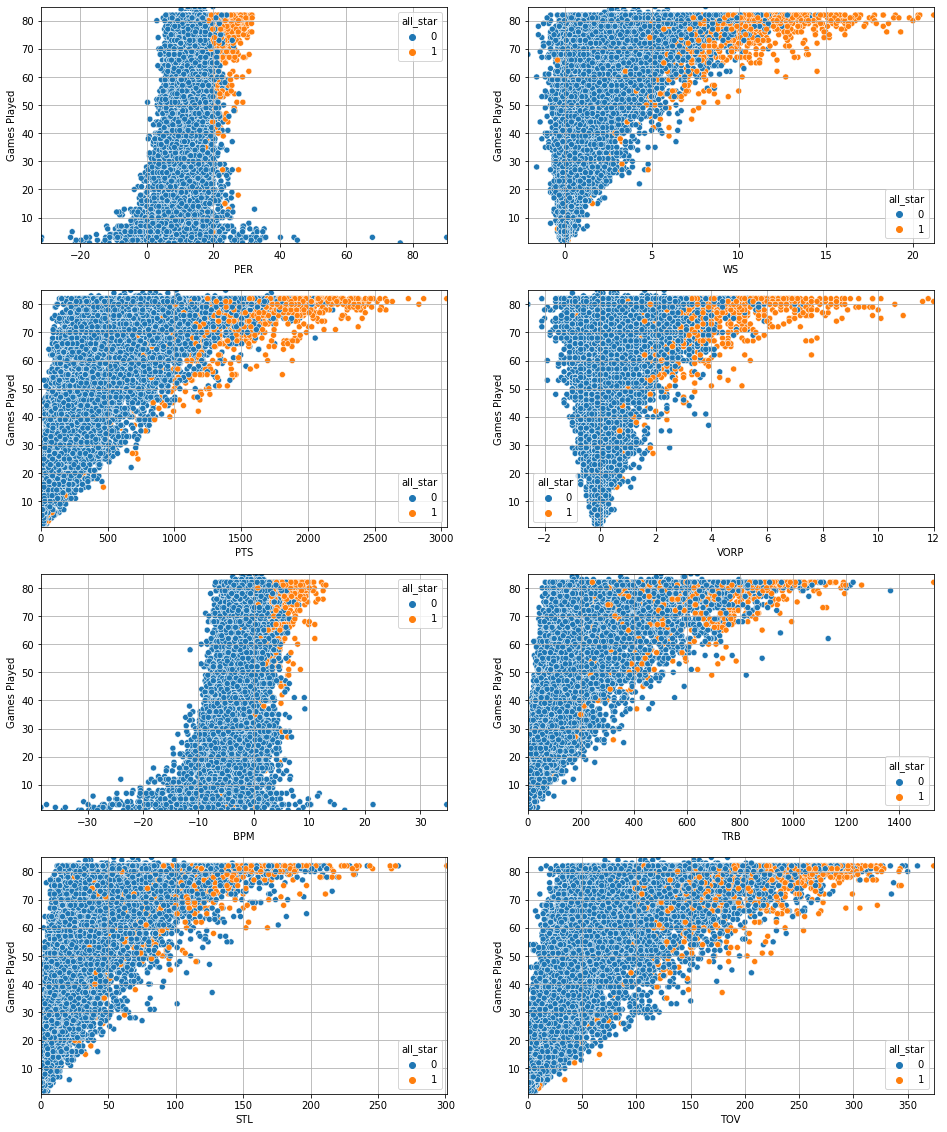

In [21]:
# Scatter plot of high correlated features by Games played ('G')

fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (16, 20))
ax = ax.ravel()
Features = ['PER', 'WS', 'PTS', 'VORP', 'BPM', 'TRB', 'STL', 'TOV']
for i, v in enumerate(Features):
    ax[i].set_xlim(df3[v].min(), df3[v].max())
    ax[i].set_ylim(df3['G'].min(), df3['G'].max())
    ax[i].set_ylabel('Games Played')
    sb.scatterplot(x = df3[v], y = df3['G'], hue = df3['all_star'], ax = ax[i])
    ax[i].grid()

In [22]:
# Selecting the records to be dropped in each feature

df3 = df3.drop(df3[(df3.all_star == 1) & (df3.TOV < 100)].index)
df3 = df3.drop(df3[(df3.all_star == 1) & (df3.STL < 40)].index)
df3 = df3.drop(df3[(df3.all_star == 1) & (df3.BPM < 0)].index)
df3 = df3.drop(df3[(df3.all_star == 1) & (df3.TRB < 250)].index)
df3 = df3.drop(df3[(df3.all_star == 1) & (df3.VORP <= 1)].index)
df3 = df3.drop(df3[(df3.all_star == 1) & (df3.PTS < 1000)].index)
df3 = df3.drop(df3[(df3.all_star == 1) & (df3.WS < 5)].index)
df3 = df3.drop(df3[(df3.all_star == 1) & (df3.PER < 17)].index)

<AxesSubplot:xlabel='G'>

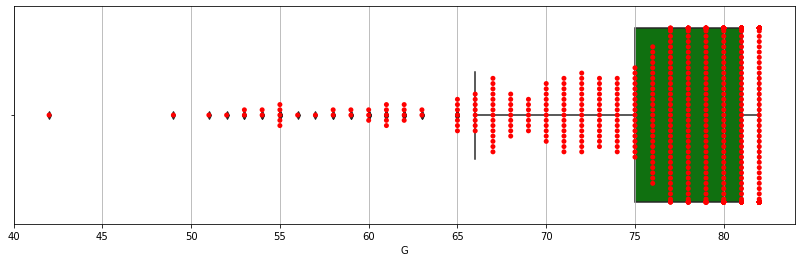

In [23]:
# Boxplot of the Games Played feature ('G') by All-Stars

plt.figure(figsize = (14, 4))
plt.grid()
sb.boxplot(x = df3['G'][df3.all_star == 1], color = 'g')
sb.swarmplot(x = df3['G'][df3.all_star == 1], color = 'r')

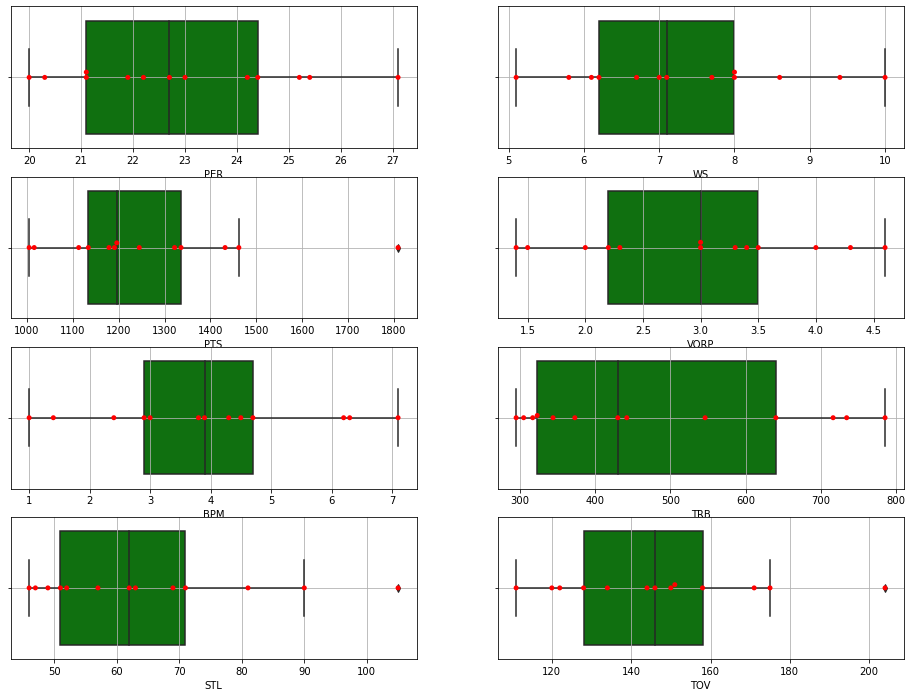

In [24]:
# Boxplot of of these four features by All-Stars where Games Played feature ('G') less than 55

fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (16, 12))
ax = ax.ravel()
Features = ['PER', 'WS', 'PTS', 'VORP', 'BPM', 'TRB', 'STL', 'TOV']
for i, v in enumerate(Features):
    ax[i].set_xlabel(v)
    sb.boxplot(x = df3[v][(df3.all_star == 1) & (df3.G <= 55)], color = 'g', ax = ax[i])
    sb.swarmplot(x = df3[v][(df3.all_star == 1) & (df3.G <= 55)], color = 'r', ax = ax[i])
    ax[i].grid()

In [25]:
# removing records

temp = df3.shape
Features = ['PER', 'WS', 'PTS', 'VORP'] #, 'BPM', 'TRB', 'STL', 'TOV']

for i in Features:
    Q1 = df3[i][(df3.all_star == 1) & (df3.G <= 50)].quantile(0.25)
    df3 = df3.drop(df3[(df3[i] < Q1) & (df3.G <= 50) & (df3.all_star == 1)].index)

print('Rows before dropping 2017', temp[0])
print('Rows after dropping 2017', df3.shape[0])

Rows before dropping 2017 16822
Rows after dropping 2017 16821


In [26]:
# Creating new features calculated by game played

new_features = ['PER', 'WS', 'PTS', 'VORP'] 

for i in new_features:
    df3[i + '_G'] = df3[i]/df3['G']

df3.columns   

Index(['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'PER', 'TS%', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'WS', 'BPM', 'VORP', 'FT%',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'all_star', 'FG_avg%',
       'PER_G', 'WS_G', 'PTS_G', 'VORP_G'],
      dtype='object')

# Pre-Processing


#### Feature Selection

<AxesSubplot:title={'center':'Feature correlation with the target'}>

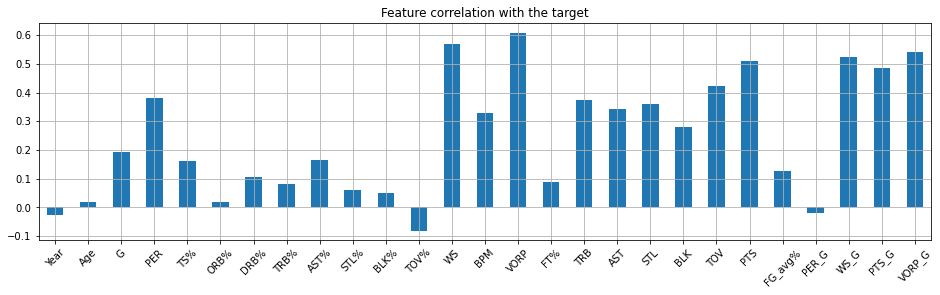

In [27]:
# Correlation among features and the target

df3.drop('all_star', axis = 1).corrwith(df3.all_star).plot.bar(
                                  figsize = (16, 4), title = 'Feature correlation with the target',
                                  rot = 45, grid = True)

- Based on the graph above, the follwing features will be removed: Year, ORB%, STL%, BLK%

In [28]:
df3 = df3.drop(['Player', 'Year', 'ORB%', 'STL%', 'BLK%'], axis = 1)

#### Encoding Categorical data

In [29]:
# Categorical Data
 
dummed_df1 = pd.get_dummies(df3[['Tm', 'Pos']], prefix = ['Tm_', 'Pos_'])  
target     = df3['all_star']
df3        = df3.drop(['all_star', 'Tm', 'Pos'], axis = 1).join(dummed_df1)
df3        = df3.join(target)
df3.head(3)

,Age,G,PER,TS%,DRB%,TRB%,AST%,TOV%,WS,BPM,...,Pos__PG-SF,Pos__PG-SG,Pos__SF,Pos__SF-PF,Pos__SF-SG,Pos__SG,Pos__SG-PF,Pos__SG-PG,Pos__SG-SF,all_star
0,32.0,82.0,25.3,0.639,22.2,15.4,16.5,15.7,14.8,6.7,...,0,0,0,0,0,0,0,0,0,1
1,25.0,67.0,11.0,0.511,12.0,8.6,9.3,9.9,2.0,-1.6,...,0,0,0,0,0,0,0,0,0,0
2,25.0,75.0,19.2,0.571,22.4,15.4,21.6,18.2,7.0,4.4,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Split Data

X_train, X_test, y_train, y_test = train_test_split(df3.drop(['all_star'], axis = 1),
                                                    df3['all_star'], test_size = 0.3,
                                                    random_state = 0)

#### Feature Scaling

In [31]:
# Scaling with standardization

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Part 3: Classification

### Build a classifier that predicts whether or not a player makes an All-Star team based on their stats for that season

In [32]:
def metrics(y_test, y_pred):
    i = [f1_score(y_test, y_pred),
         recall_score(y_test, y_pred),
         precision_score(y_test, y_pred),
         accuracy_score(y_test, y_pred)]
    a = pd.DataFrame(i, index = ['F1_score', 'Recall', 'Precision', 'Acc'])
    print(a)

def cm_(y_test, y_pred):
    cm    = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
    sb.set(font_scale = 1.4)
    sb.heatmap(df_cm, annot = True, fmt = 'g')
    
def plot_roc_curve(fdr, tpr):
    plt.plot(fpr, tpr, color = 'orange', label = 'ROC')
    plt.plot([0,1], [0,1], color = 'darkblue', linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend
    plt.show()

### Logistic Regressor

In [33]:
lr_model = LogisticRegression()                 # Classifier model
lr_model.fit(X_train, y_train)                  # Training model
ytrain_pred = lr_model.predict_proba(X_train)   # Y_pred (train dataset)
ytest_pred  = lr_model.predict_proba(X_test)    # Y_pred (test dataset)

print('LR train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
print('LR test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

LR train roc-auc: 0.9958077240080067
LR test roc-auc: 0.9942719428056973


- Selecting best threshold

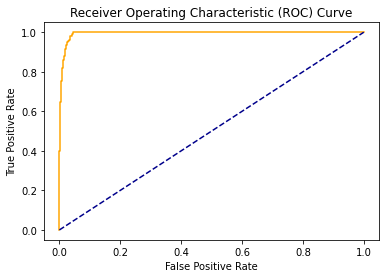

,Thresholds,Acc,F1,Recall,Precision
55,0.368029,0.984347,0.789333,0.795699,0.783069
54,0.380363,0.984347,0.788204,0.790323,0.786096
56,0.357720,0.984149,0.787234,0.795699,0.778947


In [34]:
pred_proba = pd.Series(lr_model.predict_proba(X_test)[:,1])   # Probabilitic prediction from Test dataset

fpr, tpr, thresholds = roc_curve(y_test, pred_proba)          # Calculate the ROC curve | Getting the threasholds

# Metrics Performance for each threshold
acc_  = []
f1_   = []
rec_  = []
prec_ = []

for thres in thresholds:
    y_pred = np.where(pred_proba > thres, 1, 0)
    acc_.append(accuracy_score(y_test, y_pred, normalize = True))
    f1_.append(f1_score(y_test, y_pred))
    rec_.append(recall_score(y_test, y_pred))
    prec_.append(precision_score(y_test, y_pred))
    
thres_metric = pd.concat([pd.Series(thresholds),
                     pd.Series(acc_),
                     pd.Series(f1_),
                     pd.Series(rec_),
                     pd.Series(prec_)], axis = 1)

thres_metric.columns = ['Thresholds', 'Acc', 'F1', 'Recall', 'Precision']
thres_metric.sort_values(by = 'F1', ascending = False, inplace = True)

plot_roc_curve(fpr, tpr)         # ROC Curve
thres_metric.head(3)             # Metrics Performance for each threshold

### Model Selection

In [35]:
# Grid Search (Hyperparameter Tunning)

start_time = time.time()

# Logistic Rregression parameters
parameters = [{'penalty'  : ['l2'], 'solver' : ['lbfgs'], 'C' : [1, 10, 100, 1000], 'max_iter': [100, 300]},
              {'penalty'  : ['l2'], 'solver' : ['newon-cg'], 'C' : [1, 10, 100, 1000], 'max_iter': [100, 300]},
              {'penalty'  : ['l2'], 'solver' : ['sag'], 'C' : [1, 10, 100, 1000], 'max_iter': [100, 300]},
              {'penalty'  : ['l1', 'l2', 'elasticnet'], 'solver' : ['liblinear'], 'C' : [1, 10, 100, 1000], 'max_iter': [100, 300]},
              {'penalty'  : ['elasticnet'], 'solver' : ['saga'], 'C' : [1, 10, 100, 1000], 'max_iter': [100, 300]}]

grid_search = GridSearchCV(estimator = lr_model, 
                           param_grid = parameters,
                           scoring = 'f1',
                           cv = 10,
                           n_jobs = -1)

grid_model     = grid_search.fit(X_train, y_train)
y_pred_grid    = grid_model.predict(X_test)

print('Best score: ', grid_search.best_score_)
print('Best parameters: ', grid_search.best_params_)
print("--- %s seconds ---" % (time.time() - start_time))

Best score:  0.7775171435258506
Best parameters:  {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
--- 456.64092326164246 seconds ---


                  0
F1_score   0.781915
Recall     0.773684
Precision  0.790323
Acc        0.983753


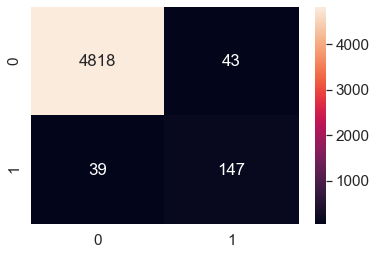

In [36]:
# Logistic Regression Model

thres = thres_metric.iloc[0,0]   # Threshold 

lr_model = LogisticRegression(C = 1,
                              max_iter = 100,
                              penalty = 'l1',
                              solver = 'liblinear',
                              random_state = 0) 

lr_model.fit(X_train, y_train)                               # Training model 
ytest_pred = lr_model.predict_proba(X_test)                  # Predict probability
ytest_pred = np.where(ytest_pred[:, 1] > thres, 1, 0)        # Setting threshold

metrics(ytest_pred, y_test)   # Metrics
cm_(y_test, ytest_pred)       # Confusion Matrix

# Final Comments


###### Classification Metrics
- The main metric used in this assignment is the F1_SCORE because it takes into account FN (False Negative) and FP (False Positive). However, the threshold to classify the prediction must change according to the metric used.
- Different classification metrics, such as Recall (focus on FN) and Precision (focus on FP), could be used depending on the business goal. 

###### The model
- Different Machile Learning models were tested, and Logistic Regression presented the best performance.
- In general, the feature engineering process improved the model from 63% to 78.19% (f1_score).
- Removing outliers improved the model in nearly 7%.
- Feature selection improved the model in 3%.
- The parameters optimization improved the model in 2%
- Every feature has been tested in the model in order to get the best performance.
